**Previous**: [Single Node Logistic Regression](GOL_LR.ipynb)  
# Deep Learning with Game Of Life, Part III
# Multi-Layer Neural Net

In this exercise, my plan was to implement a multi-layer neural network and see how using a softmax function at the output layer changes the scenario as compared to simply applying sigmoid function in a single node.

My hypothesis was that adding layers will give better accuracy than the single node logistic regression which resulted in success rate of ~76%. Also, I had a hunch that using softmax at the output layer may help to gain some more accuracy, as the problem is not actually binary but depends on both the neighboring cells AND the status of the center cell at each iteration.


### Training set size + distribution

In the previous notebook I used 50/50 split for the training + test set. When building the multi-layer model it soon started to look like I could do with a smaller amount of training data. After a number of test runs I managed to get the model to converge with 12% of the dataset, meaning that 60 sample permutations were enough for training the model (24 empty, 6 spawning, 10 living, 20 dying), with all the tested activation/optimisation/output layer combinations.

This notebook uses fixed random seeds to produce identical results in different runs. I played around with real random data, and it appeared to be pretty easy to retune the model towards 100% accuracy if it did not hit the target immediately after changing the seed. I figured however that it might be a good idea to make sure that the edge cases make it in the training set (permutations 0 and 511, i.e. all cells in the 3x3 grid dead and all cells live). This way the model learns how to treat all-dead or all-live neighborhoods, which might otherwise be difficult to predict correctly.




In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as clrs

%matplotlib inline

# Import local utility functions
from utils import gol_utils as gol

## Create all possible permutations of 3x3 array
permutations = np.asarray([gol.bitfield(x) for x in range(0, (2**9))])

# Use a fixed seed for random ops to get uniform results in runs
np.random.seed(2)

## Prepare the sets for all combinations of pre/post iteration statuses, with a shuffled set
## To make sure that fully empty + fully populated scenarios are in the train set, first
## shuffle permutations 1-510 and then insert permutations 0 and 511 to the beginning of set 
shuffled = permutations.copy()[1:len(permutations)-1:]
np.random.shuffle(shuffled)

edge_cases = np.array([np.zeros_like(permutations[0]), np.ones_like(permutations[0])])
shuffled = np.concatenate((edge_cases, shuffled))

centers = np.asarray([(p[1][1]) for p in shuffled])
truths = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in shuffled])

lived = shuffled[(1 == centers) & (1 == truths)]
spawned = shuffled[(0 == centers) & (1 == truths)]
died = shuffled[(1 == centers) & (0 == truths)]
empty = shuffled[(0 == centers) & (0 == truths)]

# create the training set, 12% of each permutation type
bias_spawned = int(spawned.shape[0] / 100 * 12)
bias_died = int(died.shape[0] / 100 * 12)
bias_lived = int(lived.shape[0] / 100 * 12 )
bias_empty = int(empty.shape[0] / 100 * 12 )

train_set_x = np.concatenate((spawned[:bias_spawned:],
                              empty[:bias_empty:],
                              lived[:bias_lived:], 
                              died[:bias_died:]))

test_set_x = np.concatenate((spawned[bias_spawned::],
                            empty[bias_empty::],
                            lived[bias_lived::],
                            died[bias_died::]))

train_set_y = np.concatenate((np.ones([1, bias_spawned]),
                             np.zeros([1, bias_empty]),
                             np.ones([1, bias_lived]),
                             np.zeros([1, bias_died])), axis=1) 

perms = len(permutations)
test_set_y = np.concatenate((np.ones([1, perms-bias_spawned]),
                             np.zeros([1, perms-bias_empty]),
                             np.ones([1, perms-bias_lived]),
                             np.zeros([1, perms-bias_died])), axis=1)

# Flatten the train and test sets along the first axis (ending up with (9,m) sized arrays)
train_set_x_flat = train_set_x.reshape(train_set_x.shape[0], -1).T
test_set_x_flat = test_set_x.reshape(test_set_x.shape[0], -1).T

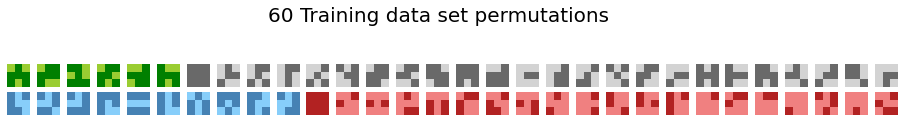

In [2]:
plt.figure(figsize=(16,8))

colors = {"00":clrs.ListedColormap(['dimgray','lightgray']), #empty cells that stay dead
          "01":clrs.ListedColormap(['g','yellowgreen']),     #cells that spawn
          "11":clrs.ListedColormap(['steelblue','lightskyblue']), #alive cells that stay alive
          "10":clrs.ListedColormap(['firebrick', 'lightcoral'])} #alive cells that die

for index in range(0, train_set_x.shape[0]):
    old = train_set_x[index][1][1]
    new = gol.life_step_standard_rules(train_set_x[index])[1][1]
    colorkey = str(old)+str(new)
    key = colors[colorkey]
    plt.subplot(16, 30, index+1)
    plt.suptitle("60 Training data set permutations", fontsize=20)
    plt.axis("off")
    plt.imshow(train_set_x[index], cmap=key)

### Hidden layers configuration

Working with just one hidden layer it was pretty straightforward to get the model to fit with the training set. However, getting 100% accurate predictions with 1 hidden layer on the non-trained permutations did not work out, regardless of applying regularisation while training (L2 / dropout).

Depending on the chosen activation functions, the best results were achieved with **2-3 hidden layers**. Adding more layers did not seem to raise the probability to hit 100% rates. Number of nodes needed in the hidden layer depended on the activation function; for ReLU layers generally more nodes were required for better results, whereas tanh activated layers could perform with significantly smalle number of nodes and iterations, especially when adaptive momentum ([ADAM](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)) algorithm was applied in backpropagation. 


### Activation functions

##### ReLU
Based on the deeplearning.ai course material and some googling, I started out using [ReLU](https://algorithmsdatascience.quora.com/ReLu-compared-against-Sigmoid-Softmax-Tanh) for activation in my multi-layer neural net. The following observations were made while iterating with ReLU activation in hidden layers:
1. Using ReLU for getting 100% accuracy on the data set required relatively long training (thousands of iterations)
2. Relatively large hidden layers (512 + 15) were needed as compared to other options. 
3. Standard gradient descent algorithm performed better than adaptive variant (ADAM)
4. The layer size distribution is crucial success factor, nudging the values may result in so called [Dying ReLU](https://machinelearning.wtf/terms/dying-relu/) phenomenon where the activation starts to produce same result regardless of the input data. Applying a [leaky-relu](https://machinelearning.wtf/terms/leaky-relu/) variant helps a bit, but many configurations still tend to die and predict death for all permutations.

##### Softmax

[Softmax function](https://machinelearning.wtf/terms/softmax/) is often used when there is a need to classify the result as one of N where N > 2. In the Game of life ruleset, the result of iteration in a moore neighborhood is binary (either 0 or 1) and therefore sigmoid function works just fine in these scenarios. I was curious to know how softmax would perform here though, the network would learn not only what is the resulting state of the center cell, but it would also be able to tell why the state is what it is. A softmax output layer can tell if the cell is dead because it has too little or too much life around it, or if the cell becomes live thanks to reproduction or lives over to next generation due to the optimum neighboring cell count. In this sense, the model learns more about the data than in basic binary classification. 

For a person just familiarised with numpy and having touched matrix arithmetic last in high school it took some iterations for me to get the softmax forward and backward prop going, but eventually it started to converge. Some observations:

1. Quite naturally softmax function in the output layer results in higher cost throughout the cycle, especially at the start of learning
2. Large hidden layers are again needed for accurate results (512 + 200)
3. The model overfits aggressively to training data, had to use both L2 regularisation and dropout to get to 100% prediction accuracy.
4. Number of iterations required for 100% accuracy was lower than with ReLU/Adam but several times larger than with Tanh/Adam setup. 

##### Tanh

Tanh is practically [sigmoid function rescaled](https://brenocon.com/blog/2013/10/tanh-is-a-rescaled-logistic-sigmoid-function/), and usually performs better than sigmoid in hidden layers. Using tanh as activation function with batch gradient descent optimisation also acquired 100% accuracy, but with yet larger number of iterations than ReLU. However, when switching to adaptive gradient descent optimisation, the picture changes drastically. The following observations were made while testing tanh in the hidden layers:

1. Using TanH with batch gradient descent required a relatively long training (even longer than RelU + BGD) and large hidden layers (512 + 128)
2. When changing over to adaptive gradient descent algorithm with tanh activation, it made the network converge much faster (i.e. with less iterations)
3. Tanh + Adam combination produced 100% accuracy with smaller number of nodes, if one more layer was added to the configuration (15 + 15 + 15)

### Cost graphs from different activation / optimisation configurations

The next cell will plot cost/accuracy graphs per iteration from my test runs with a number of different model configurations. It is likely that these can be further adjusted towards more performant execution by adding more backprop optimisation methods, more fine-grained control over activation functions in layers etc, but this will do for a DIY exercise. 


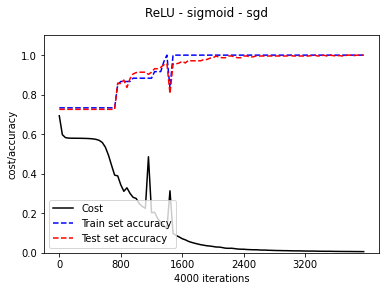

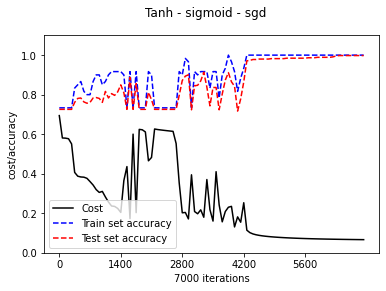

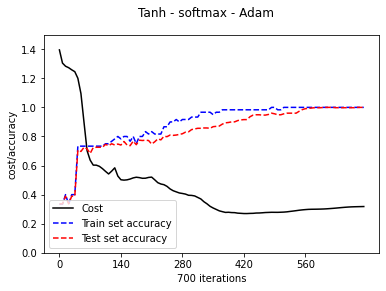

In [3]:
def plotGraph(datapack, itrs, title):
    costs, acc1, acc2 = datapack
    a,b,c = plt.plot(costs, 'black', acc1, 'b--', acc2, 'r--')
    plt.legend([a, b, c], ["Cost", "Train set accuracy", "Test set accuracy"], loc='lower left')
    plt.suptitle(title)
    axes = plt.gca()
    axes.set_ylim([0,np.maximum(max(costs), np.maximum(max(acc2), max(acc1)))+0.1])
    ticks = np.arange(0, 100, 100/5)
    labels = np.arange(0, itrs, itrs/5, dtype=int)
    plt.xticks(ticks, labels)
    plt.xlabel(str(itrs) + " iterations")
    plt.ylabel("cost/accuracy")
    plt.show()

res = np.loadtxt("data/[9-512-15-1]-0.0-0.1-4000-relu-gd.txt")
plotGraph(res, 4000, "ReLU - sigmoid - sgd")

res = np.loadtxt("data/[9-512-15-1]-0.1-0.2-7000-tanh-gd.txt")
plotGraph(res, 7000, "Tanh - sigmoid - sgd")

res = np.loadtxt("data/[9-512-200-4]-0.1-0.006-700-softmax-adam-0.99-0.9997-1e-08.txt")
plotGraph(res, 700, "Tanh - softmax - Adam")

# The best architecture with TanH activation, Adam optimization adn 15-15-15-1 layer setup
#res = np.loadtxt("[9-15-15-15-1]-0.1-0.01-160-tanh-adam-0.9-0.999-1e-07.txt")
#plotGraph(res, 160, "Tanh - sigmoid - Adam")


### Learning Model

The best Neural Network architecture that I managed to find with this fully connected NN approach is implemented below. It manages to produce 100% prediction accuracy trained with 60 examples over 160 iterations. The result is achieved using TanH activation in three layers that have 15 nodes each, sigmoid in the output layer and and Adam optimization in backprop. The starting point for this code is from the programming exercises of [Deeplearning.ai](Deeplearning.ai) second course [Improving Deep Neural Networks](https://www.coursera.org/learn/deep-neural-network/home/welcome), I've added Adam optimisation and some other customisation features on top of that.

In [4]:
   
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def tanh(Z):
    A = np.tanh(Z)
    cache = Z
    return A, cache

def tanh_backward(dA, cache):
    Z = cache
    output = np.tanh(Z)
    dZ = (1.0 - np.square(output)) * dA
    assert(dZ.shape == Z.shape)
    return dZ

def relu(Z):
    A = np.maximum(0.01 * Z, Z)
    assert (A.shape == Z.shape)
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    Z = np.asarray(cache)
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ


def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    assert (dZ.shape == Z.shape)
    return dZ


def initialize_parameters_deep(layer_dims):
    parameters = {}
    np.random.seed(1)
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters


def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters


def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    elif activation == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache


def linear_backward(dZ, cache, lambd=0.0):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1./m * np.dot(dZ,A_prev.T) + (lambd * W) / m
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    db = np.sum(db)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (isinstance(db, float))

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation, lambd = 0.0):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)

    return dA_prev, dW, db


def update_parameters(parameters, grads, learning_rate):
    for l in range(len(parameters)):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    return parameters

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2                 # number of layers
    v_corrected = {}                         # 1st moment dict
    s_corrected = {}                         # 2nd moment dict
    
    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))

        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))

        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s["db" + str(l + 1)] + epsilon)

    return parameters, v, s

def initialize_adam(parameters) :
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v, s

def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    cost = np.squeeze(cost)
    assert (cost.shape == ())
    return cost

def compute_cost_with_regularization(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters) // 2
    squared = 0.0
    for l in range(L):
        W = parameters["W" + str(l+1)]
        squared = squared + np.sum(np.square(W))
    cross_entropy_cost = compute_cost(AL, Y)
    L2_regularization_cost = lambd * squared / (2*m)
    cost = cross_entropy_cost + L2_regularization_cost
    return cost

def L_model_backward(AL, Y, caches, lambd = 0.0, af='relu'):
    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # reshape Y to match AL shape

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    dA_g = "dA" + str(L)
    dW_g = "dW" + str(L)
    db_g = "db" + str(L)
    grads[dA_g], grads[dW_g], grads[db_g] = linear_backward(sigmoid_backward(dAL,
                                                                             current_cache[1]),
                                                            current_cache[0], lambd)

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], 
                                                                    current_cache, 
                                                                    activation = af, lambd = lambd)
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads


def L_model_forward(X, parameters, af='relu'):
    caches = []
    A = X
    L = len(parameters) // 2  

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)],
                                             parameters['b' + str(l)],
                                             activation=af)
        caches.append(cache)

    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          activation='sigmoid')
    caches.append(cache)
    assert (AL.shape == (1, X.shape[1]))
    return AL, caches


def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=5000, lambd = 0.0, af='relu', print_cost=False, sample_accuracy=False):  # lr was 0.009
    costs = []  
    trainhits = []
    testhits = []

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters, af)

        cost = compute_cost_with_regularization(AL, Y, parameters, lambd = lambd)
        grads = L_model_backward(AL, Y, caches, lambd, af)
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every nth training example
        if print_cost and i % int(num_iterations/5) == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % int(num_iterations/100) == 0:
            costs.append(cost)
            if sample_accuracy:
                acc1, acc2 = currentAccuracies(parameters, af)
                trainhits.append(acc1)
                testhits.append(acc2)
            else:
                trainhits.append(0)
                testhits.append(0)

    return parameters, costs, trainhits, testhits

def L_layer_model_adam(X, Y, layers_dims, learning_rate=0.001, num_iterations=10000,
          beta1=0.9, beta2=0.999, epsilon=1e-8, lambd = 0.0, af='relu', print_cost=False, sample_accuracy=False):

    parameters = initialize_parameters_deep(layers_dims)
    v, s = initialize_adam(parameters)
    t = 0 
    costs = []
    trainhits = []
    testhits = []
    for i in range(0, num_iterations):
        t = t + 1
        AL, caches = L_model_forward(X, parameters, af)

        cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
        grads = L_model_backward(AL, Y, caches, lambd, af)
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        # Print the cost every nth training example
        if print_cost and i % int(num_iterations/5) == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % int(num_iterations/100) == 0:
            costs.append(cost)
            if sample_accuracy:
                acc1, acc2 = currentAccuracies(parameters, af)
                trainhits.append(acc1)
                testhits.append(acc2)
            else:
                trainhits.append(0)
                testhits.append(0)
    return parameters, costs, trainhits, testhits

def predict(X, parameters, af='relu'):
    m = X.shape[1]
    n = len(parameters) // 2  
    p = np.zeros((1, m))

    probas, caches = L_model_forward(X, parameters, af)
    p = probas > 0.5
    return p

def currentAccuracies(parameters, af='relu'):
    preds_train = predict(train_set_x_flat, parameters, af)
    truths_train = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in train_set_x])
    trainhit = np.sum((preds_train == truths_train)/train_set_x.shape[0])

    preds_test = predict(test_set_x_flat, parameters, af)
    truths_test = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in test_set_x])
    testhit = np.sum((preds_test == truths_test)/test_set_x.shape[0])
    return trainhit, testhit


### Executing model on the data

It is possible to tune the layer sizes and other hyperparameters by changing the variables below. The given values are the ones that I found out working best.

Note that due to sampling prediction accuracy on both train and test sets for 100 times during learning it takes some time to run the model. If you set ```sampleAccuracy``` variable to ```False``` you'll get the result *much* faster.

The version that uses softmax at the final layer is implemented separately since I did not want to break a working model. Enabling softmax at the output layer required also rebuilding the train/test sets differently, and I found it too tedious to implement in the same notebook by hand. For the softmax version, see [GOL_NN_Softmax.ipynb](GOL_NN_Softmax.ipynb) 

Cost after iteration 0: 0.693197
Cost after iteration 32: 0.580100
Cost after iteration 64: 0.438803
Cost after iteration 96: 0.284177
Cost after iteration 128: 0.124181
Train set accuracy: 1.0
Test set accuracy: 1.0
Overall Accuracy: 1.0


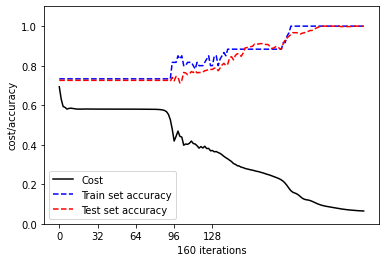

In [5]:
layers_dims = [9,15,15,15,1] 
lambd = 0.1
lr = 0.01
itrs = 160
beta1 = 0.9
beta2 = 0.999
eps = 0.0000001
fx ='tanh'
opt = 'adam'
sampleAccuracy = True #set to False to bypass accuracy sampling => Much faster execution
if opt == 'gd':
    params, costs, acc1, acc2 = L_layer_model(train_set_x_flat, train_set_y, layers_dims, num_iterations=itrs, learning_rate=lr, lambd = lambd, af=fx, print_cost=True, sample_accuracy=sampleAccuracy)
if opt == 'adam':
    params, costs, acc1, acc2 = L_layer_model_adam(train_set_x_flat, train_set_y, layers_dims, num_iterations=itrs, learning_rate=lr, beta1=beta1, beta2=beta2, epsilon=eps, lambd=lambd, af=fx, print_cost=True, sample_accuracy=sampleAccuracy)
    
p_flat = permutations.reshape(permutations.shape[0], -1).T
truths = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in permutations])
predictions = predict(p_flat, params, fx)

preds_train = predict(train_set_x_flat, params, fx)
truths_train = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in train_set_x])
print("Train set accuracy: "  + str(np.sum((preds_train == truths_train)/train_set_x.shape[0])))

preds_test = predict(test_set_x_flat, params, fx)
truths_test = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in test_set_x])
print("Test set accuracy: "  + str(np.sum((preds_test == truths_test)/test_set_x.shape[0])))

p_flat = permutations.reshape(permutations.shape[0], -1).T
truths = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in permutations])
predictions = predict(p_flat, params, fx)

accuracy = np.sum((predictions == truths)/predictions.shape[1])
print("Overall Accuracy: "  + str(accuracy))

res = np.array([costs, acc1, acc2])

## Save the learning history data if accuracy is 1
#if accuracy == 1:
#    filename = "data/" + str(layers_dims).replace(', ','-') +'-' +str(lambd) + '-' +  str(lr) + '-' + str(itrs) + '-' + fx + '-' + opt
#    if opt=='adam':
#        filename = filename + '-' + str(beta1) + '-' + str(beta2) + '-' + str(eps)
#    np.savetxt(filename + '.txt', res)

# Plot learning curve (with costs and accuracy)
plotGraph(res, itrs, "")

### Trained Model vs Game Of Life Algorithm - Performance Evaluation

So, we got a 100% accuracy on the Moore neighbourhoods set, meaning that the trained model learnt to decide which permutations result in the center cell "on" and which result in the center cell "off". Somewhat like I expected - considering the estimated Bayes error rate being zero - a person knowing the rules would always be able to tell the result for a single Moore neighbourhood. So far so good.

What about performance comparison then - surely the standard GOL algorithm that just counts the neighboring cells must be more efficient than the trained model with four layers? Answer to this is yes and no. I ran the animation generation Using ```%timeit``` to see how long it takes to predict the next generation of the game in a grid of varying size and compared the results with the standard algorithm. The results are illustrated within the graph below. It turned out that with grids containing 100 cells (i.e. 10 by 10) or less the trained model actually was faster than the standard algorithm. With larger grids, the standard algorithm starts to win by a lot, and you should note that the graph is plotted on a logarithmic scale to make the performance variance on very small grids stand out. With grid sizes of 40x40 cells the standard algorithm wins already by 5x, and it just explodes from there.


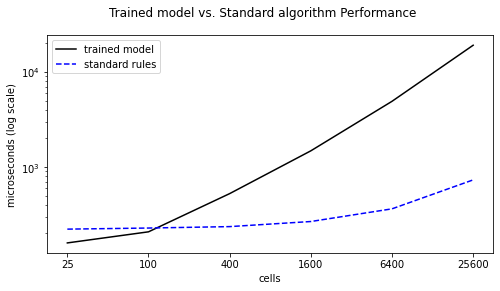

In [6]:
sizes = [5, 10, 20, 40, 80, 160]
predspeed = [159, 208, 525, 1480, 4910, 19100]
tradspeed = [222, 228, 236, 267, 363, 732]

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
a,b = ax.plot(predspeed, 'black', tradspeed, 'b--')
plt.legend([a,b],['trained model', 'standard rules'])
ticks = np.arange(len(sizes))
plt.xticks(ticks, np.multiply(sizes,sizes))
plt.suptitle("Trained model vs. Standard algorithm Performance")
plt.xlabel("cells")
plt.ylabel("microseconds (log scale)")

plt.show()

### Trained Model vs Game Of Life Algorithm - Side by Side Animation

Below code animates the trained model prediction on a grid next to the standard GOL calculation. The model produces 100% identical generations with the original GOL algorithm. You can tune the animation parameters to your liking.

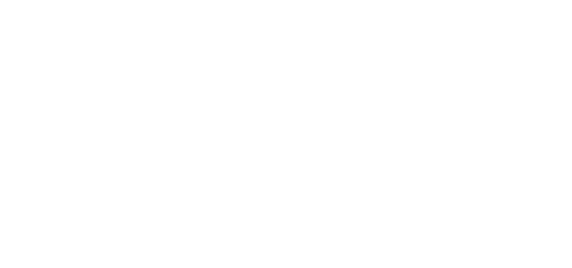

In [7]:
import timeit
from IPython.display import HTML
from matplotlib import animation

# settings for the animation 
gridsize = 50 # Size of the grid (n times n square)
gens = 100    # How many generations are animated
ival = 100    # frame interval in milliseconds (default 100 for 10 fps)

# Create a random game grid of 50% density 
GAME = gol.generate(gridsize, 0.5)
#GAME = np.random.randint(2, size=(gridsize,gridsize))
GAME_REF = GAME

def life_step_nn(GRID):
    #create rim around the game area for torus-like operation
    expGame = np.pad(GRID,[(1,1),(1,1)], mode='wrap')
    #roll the game grid into array of moore neighborhoods
    C = np.lib.stride_tricks.as_strided(expGame, shape=(gridsize, gridsize, 3, 3), strides=expGame.strides + expGame.strides)
    C2 = C.reshape((gridsize)*(gridsize),9).transpose(1,0)
    preds = predict(C2, params, fx).reshape(gridsize, gridsize)
    return preds

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.axis("off")
ax2.axis("off")
fig.set_size_inches(10, 5)

ims = []

# To print out relative time used in calculations with the trained model & original GOL algo
#%timeit life_step_nn(GAME)
#%timeit gol.life_step_standard_rules(GAME)

#render generations
for g in range(0,gens):
    im = ax1.imshow(GAME, animated=True)
    im2 = ax2.imshow(GAME_REF, animated=True)
    ims.append([im, im2])
    GAME = life_step_nn(GAME)
    GAME_REF = gol.life_step_standard_rules(GAME_REF)
    
anim = animation.ArtistAnimation(fig,ims,interval=ival)
HTML(anim.to_html5_video())

### Summary

Tuning a neural net for optimal performance both for learning speed and for prediction accuracy is a true hands-on exercise - it might be possible to figure out where to start the journey from, but finding the best fit will take time & effort. The material from [Deeplearning.ai](https://deeplearning.ai) course 3: [Structured Machine Learning Projects](https://www.coursera.org/learn/machine-learning-projects/home/welcome) helped to find ideas how to iterate towards better results, even though all the tricks were not feasible for the particular problem here, e.g. due to the rather small data sets used. 

I was considering to neatify the main neural net implementation above for a while, but then decided it'll do - for any further exercises I would be using library implementations anyway, and I'm definitely not going to go for my own [Tensorflow](https://www.tensorflow.org/) or [SKLearn](http://scikit-learn.org/stable/). 

Next parts in the series are going to be about more complex Neural Network architectures like CNN/RNN and how to apply those in the Game Of Life context. At this point I'm done with the basic problem of training a neural net to predict the fate of a Moore neighborhood center cell - it's time to find a bit more challenging problem, something where a convolutional network would prove useful. Where I'm planning to start from is to get a CNN to predict me the next generation of a larger game area and see how close I can get to the original algorithm, something in the fashion of what **Daniel Rapp** presented in his medium article [Learning Game of Life with a Convolutional Neural Network](https://danielrapp.github.io/cnn-gol/). While googling around I also bumped into a kaggle.com challenge for [Reverse Game of Life](https://www.kaggle.com/c/conway-s-reverse-game-of-life) algorithm, which could be another option for future endeavours.

**Next**: [Convolutional Neural Network](GOL_CNN.ipynb)